# Análise Exploratória de Dados (EDA) - Segurança Pública SP

Este notebook realiza uma **análise exploratória** dos dados processados pelo pipeline ETL.

## Contexto do Pipeline ETL

### 1. Extração (notebook 1)
- **Fonte**: SPDadosCriminais_2025.xlsx
- **Abas processadas**: JAN-JUN e JUN-SET
- **Registros extraídos**: 878,793 ocorrências criminais
- **Saída**: `dados_brutos_consolidados.parquet`

### 2. Transformação (notebook 2)
- **Entrada**: `dados_brutos_consolidados.parquet`
- **Transformações aplicadas**:
  - Normalização de colunas
  - Remoção de duplicatas (13 registros)
  - Filtragem: ano_bo >= 2025 e coordenadas válidas
  - Processamento de datas e features temporais
  - Categorização de crimes em 4 categorias
- **Registros finais**: 878,780
- **Saída**: `ocorrencias_criminais_2025_transformado.parquet`

### 3. Carga (notebook 3)
- **Formato final**: Parquet + DuckDB
- **Datasets gerados**:
  - Dataset completo transformado
  - Agregado por município/crime
  - Subset com coordenadas geográficas

## Objetivo desta Análise

Realizar uma exploração detalhada dos dados transformados para entender:
- Distribuições temporais e espaciais
- Padrões de criminalidade
- Características dos dados
- Qualidade e completude
- Insights para visualizações futuras

---

## 1. Importar Bibliotecas e Configurações

Importação de bibliotecas essenciais para análise exploratória de dados, incluindo pandas para manipulação, matplotlib e seaborn para visualizações, e numpy para operações numéricas. Configurações personalizadas são aplicadas para:

- Estilo visual padronizado dos gráficos
- Paleta de cores apropriada para apresentações
- Tamanho de figuras otimizado para legibilidade
- Formato de exibição de números e dataframes

Estas configurações garantem consistência visual em todas as análises e facilitam interpretação dos resultados.

In [1]:
import sys
import os
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings

warnings.filterwarnings('ignore')

# Configurar visualizações
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Configurar pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ Bibliotecas importadas")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

✓ Bibliotecas importadas
Pandas: 2.3.3
NumPy: 2.3.4


## 2. Carregar Dados Transformados

Carregamento do dataset final processado pelo pipeline ETL. Esta célula verifica a existência do arquivo transformado e carrega os dados completos em memória. Exibe informações preliminares incluindo:

- Dimensões do dataset (878.780 registros esperados)
- Uso de memória
- Tamanho do arquivo
- Confirmação de que todas as etapas anteriores foram executadas

Este ponto marca o início da análise exploratória propriamente dita, trabalhando com dados limpos e validados.

In [2]:
# Definir diretórios
PROJECT_ROOT = Path().resolve().parent
DATA_PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'

print(f"Diretório processado: {DATA_PROCESSED_DIR}")

# Carregar dataset principal
arquivo_principal = DATA_PROCESSED_DIR / 'ocorrencias_criminais_2025_transformado.parquet'

if arquivo_principal.exists():
    print(f"\nCarregando: {arquivo_principal.name}")
    df = pd.read_parquet(arquivo_principal)
    
    size_mb = arquivo_principal.stat().st_size / (1024**2)
    print(f"✓ Dados carregados com sucesso!")
    print(f"  Tamanho do arquivo: {size_mb:.2f} MB")
    print(f"  Dimensões: {df.shape[0]:,} linhas x {df.shape[1]} colunas")
    print(f"  Memória: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
else:
    print(f"ERRO: Arquivo não encontrado!")
    print("Execute primeiro os notebooks: 1_extracao.ipynb, 2_transformacao.ipynb")

# Carregar metadados
metadata_path = DATA_PROCESSED_DIR / 'metadata_transformacao.json'
if metadata_path.exists():
    with open(metadata_path, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    print(f"\n✓ Metadados carregados")
    print(f"  Data de processamento: {metadata['data_processamento']}")
    print(f"  Transformações aplicadas: {len(metadata['transformacoes_aplicadas'])}")
else:
    metadata = None
    print("\n⚠ Metadados não encontrados")

Diretório processado: C:\Users\jodes\OneDrive\Documentos\Projetos-GitHub\public-security-data\data\processed

Carregando: ocorrencias_criminais_2025_transformado.parquet
✓ Dados carregados com sucesso!
  Tamanho do arquivo: 32.26 MB
  Dimensões: 878,585 linhas x 36 colunas
  Memória: 1622.64 MB

✓ Metadados carregados
  Data de processamento: 2025-11-24T03:27:28.158627
  Transformações aplicadas: 6


## 3. Visão Geral dos Dados

Análise inicial abrangente que fornece uma compreensão rápida e completa do dataset. Esta seção apresenta:

- Dimensões totais (registros e colunas)
- Cobertura temporal dos dados
- Estrutura e tipos de dados de cada coluna
- Amostra das primeiras linhas para inspeção visual
- Estatísticas descritivas (média, mediana, quartis, desvio padrão)

Esta visão panorâmica é fundamental para orientar análises mais específicas e identificar características gerais dos dados de criminalidade em São Paulo.

In [ ]:
print("="*80)
print("VISÃO GERAL DO DATASET")
print("="*80)

# Informações básicas
print(f"\nDIMENSÕES")
print(f"  Total de registros: {len(df):,}")
print(f"  Total de colunas: {len(df.columns)}")
print(f"  Período: {df['data_ocorrencia_bo'].min()} a {df['data_ocorrencia_bo'].max()}")

# Estrutura dos dados
print(f"\nESTRUTURA")
print(df.info(verbose=False, memory_usage='deep'))

# Primeiras linhas
print(f"\nPRIMEIRAS 5 LINHAS")
display(df.head())

# Estatísticas descritivas das colunas numéricas
print(f"\nESTATÍSTICAS DESCRITIVAS")
display(df.describe())

VISÃO GERAL DO DATASET

📊 DIMENSÕES
  Total de registros: 878,585
  Total de colunas: 36
  Período: 2005-01-01 00:00:00 a 2025-12-18 00:00:00

📋 ESTRUTURA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878585 entries, 0 to 878584
Columns: 36 entries, nome_departamento to categoria_crime
dtypes: datetime64[ns](3), float64(6), int64(3), object(24)
memory usage: 1.6 GB
None

👀 PRIMEIRAS 5 LINHAS


,nome_departamento,nome_seccional,nome_delegacia,nome_municipio,num_bo,ano_bo,data_registro,data_ocorrencia_bo,hora_ocorrencia_bo,desc_periodo,descr_subtipolocal,bairro,logradouro,numero_logradouro,latitude,longitude,nome_delegacia_circunscricao,nome_departamento_circunscricao,nome_seccional_circunscricao,nome_municipio_circunscricao,rubrica,descr_conduta,natureza_apurada,mes_estatistica,ano_estatistica,cmd,btl,cia,aba_origem,ano_mes,ano_ocorrencia,mes_ocorrencia,dia_semana,dia_semana_nome,tipo_crime,categoria_crime
0,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AA2328,2025,2025-01-01,2024-12-31,18:00:00,nan,Mercado,LIBERDADE,VEDAÇÃO DA DIVULGAÇÃO DOS DADOS RELATIVOS,NaN,NaN,NaN,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Estupro de vulneravel (art.217-A),nan,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025,NaT,2024.00,12.00,1.00,Tuesday,ESTUPRO DE VULNERÁVEL,Crimes Violentos
1,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AM7136,2025,2025-01-10,2025-01-10,00:00:00,nan,Via Pública,SÉ,VEDAÇÃO DA DIVULGAÇÃO DOS DADOS RELATIVOS,NaN,NaN,NaN,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Estupro de vulneravel (art.217-A),nan,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025,NaT,2025.00,1.00,4.00,Friday,ESTUPRO DE VULNERÁVEL,Crimes Violentos
2,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,AQ9561,2025,2025-01-14,2025-01-14,nan,Em hora incerta,Casa,SÉ,VEDAÇÃO DA DIVULGAÇÃO DOS DADOS RELATIVOS,NaN,NaN,NaN,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Estupro de vulneravel (art.217-A),nan,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025,NaT,2025.00,1.00,1.00,Tuesday,ESTUPRO DE VULNERÁVEL,Crimes Violentos
3,DECAP,DEL.SEC.6º SANTO AMARO,06ª DDM SANTO AMARO,S.PAULO,BH3385,2025,2025-01-27,2025-01-25,18:00:14,nan,Motel,CANINDÉ,VEDAÇÃO DA DIVULGAÇÃO DOS DADOS RELATIVOS,NaN,NaN,NaN,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Estupro de vulneravel (art.217-A),nan,ESTUPRO DE VULNERÁVEL,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025,NaT,2025.00,1.00,5.00,Saturday,ESTUPRO DE VULNERÁVEL,Crimes Violentos
4,DIPOL - DEPTO DE INTELIGENCIA,DELEGACIA ELETRONICA,DELEGACIA ELETRONICA 1,S.PAULO,AA1448,2025,2025-01-01,2024-12-31,10:30:00,nan,Via Pública,SE,AVENIDA PREFEITO PASSOS,57.00,-23.55,-46.63,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Furto (art. 155),Outros,FURTO - OUTROS,1,2025,CPA/M1,7ºBPM/M,3ªCIA 4ªCIA,JAN_A_JUN_2025,NaT,2024.00,12.00,1.00,Tuesday,FURTO - OUTROS,Crimes Patrimoniais



📈 ESTATÍSTICAS DESCRITIVAS


,ano_bo,data_registro,data_ocorrencia_bo,numero_logradouro,latitude,longitude,mes_estatistica,ano_estatistica,ano_mes,ano_ocorrencia,mes_ocorrencia,dia_semana
count,878585.00,878585,878577,714599.00,637016.00,637016.00,878585.00,878585.00,0,878577.00,878577.00,878577.00
mean,2025.00,2025-05-15 19:31:01.431734784,2025-05-03 13:08:07.979539712,927136.73,-23.21,-120.43,4.98,2025.00,NaT,2024.96,5.06,2.93
min,2025.00,2025-01-01 00:00:00,2005-01-01 00:00:00,0.00,-46.43,-46779670.00,1.00,2025.00,NaT,2005.00,1.00,0.00
25%,2025.00,2025-03-07 00:00:00,2025-03-02 00:00:00,76.00,-23.61,-47.02,3.00,2025.00,NaT,2025.00,3.00,1.00
50%,2025.00,2025-05-14 00:00:00,2025-05-09 00:00:00,277.00,-23.53,-46.67,5.00,2025.00,NaT,2025.00,5.00,3.00
75%,2025.00,2025-07-24 00:00:00,2025-07-22 00:00:00,830.00,-23.13,-46.55,7.00,2025.00,NaT,2025.00,7.00,5.00
max,2025.00,2025-09-30 00:00:00,2025-12-18 00:00:00,9999999999.00,23.53,-40.05,9.00,2025.00,NaT,2025.00,12.00,6.00
std,0.00,NaN,NaN,79673840.44,0.81,58611.33,2.60,0.00,NaN,0.44,2.71,1.95


## 4. Qualidade dos Dados

Avaliação sistemática da qualidade e completude do dataset processado. Esta análise identifica:

- Colunas com valores ausentes e suas proporções
- Registros duplicados remanescentes
- Integridade referencial dos dados
- Consistência entre campos relacionados
- Taxa de completude por coluna crítica

A qualidade dos dados impacta diretamente a confiabilidade das análises. Esta seção documenta quaisquer limitações que devem ser consideradas na interpretação dos resultados.

ANÁLISE DE QUALIDADE DOS DADOS

🔍 VALORES AUSENTES

Colunas com valores ausentes: 8


,Coluna,Valores Ausentes,Percentual (%)
0,ano_mes,878585,100.00
1,latitude,241569,27.50
2,longitude,241569,27.50
3,numero_logradouro,163986,18.66
4,mes_ocorrencia,8,0.00
5,ano_ocorrencia,8,0.00
6,dia_semana,8,0.00
7,data_ocorrencia_bo,8,0.00


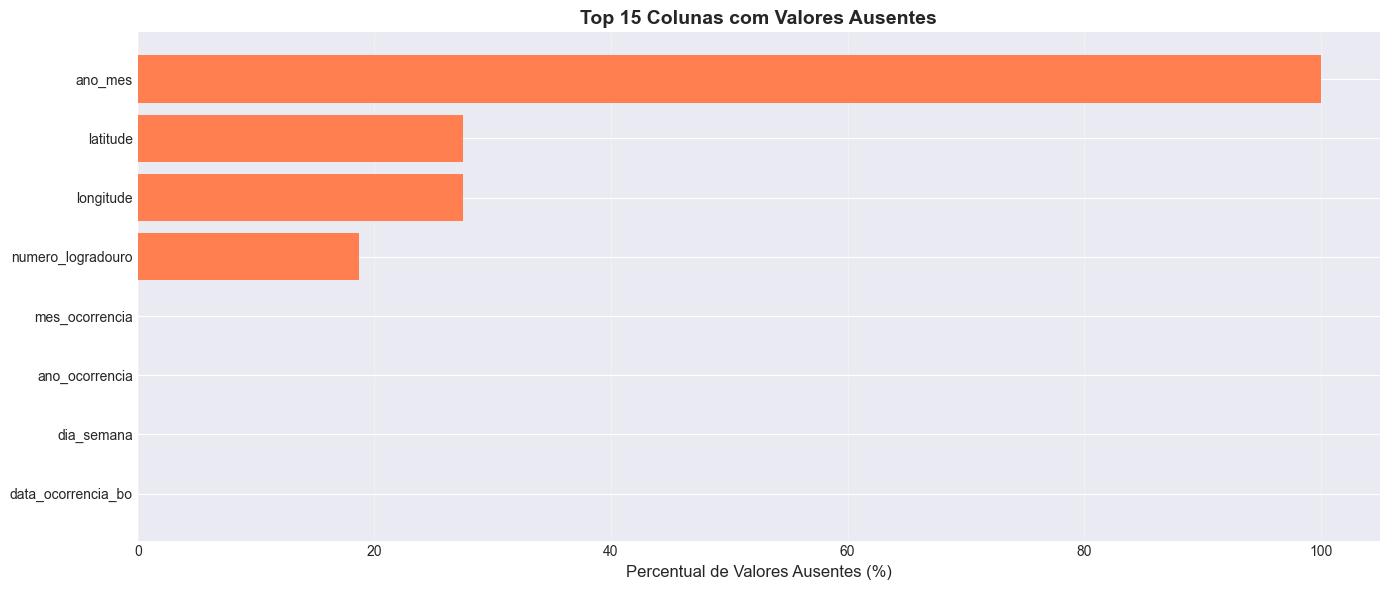


📋 DUPLICATAS
  Total: 0 (0.00%)

🌍 COORDENADAS GEOGRÁFICAS
  Completas: 637,016 (72.50%)
  Ausentes: 241,569 (27.50%)

⚡ COLUNAS CRÍTICAS
  tipo_crime                     ✓ OK
  categoria_crime                ✓ OK
  nome_municipio                 ✓ OK
  data_ocorrencia_bo             ⚠ 8 ausentes


In [ ]:
print("="*80)
print("ANÁLISE DE QUALIDADE DOS DADOS")
print("="*80)

# Valores ausentes
print(f"\nVALORES AUSENTES")
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Coluna': missing.index,
    'Valores Ausentes': missing.values,
    'Percentual (%)': missing_pct.values
})

# Mostrar apenas colunas com valores ausentes
missing_df = missing_df[missing_df['Valores Ausentes'] > 0]

if len(missing_df) > 0:
    print(f"\nColunas com valores ausentes: {len(missing_df)}")
    display(missing_df.head(20))
    
    # Visualização
    fig, ax = plt.subplots(figsize=(14, 6))
    top_missing = missing_df.head(15)
    ax.barh(range(len(top_missing)), top_missing['Percentual (%)'], color='coral')
    ax.set_yticks(range(len(top_missing)))
    ax.set_yticklabels(top_missing['Coluna'])
    ax.set_xlabel('Percentual de Valores Ausentes (%)')
    ax.set_title('Top 15 Colunas com Valores Ausentes', fontweight='bold', fontsize=14)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nNenhum valor ausente encontrado!")

# Duplicatas
duplicatas = df.duplicated().sum()
print(f"\n📋 DUPLICATAS")
print(f"  Total: {duplicatas:,} ({duplicatas/len(df)*100:.2f}%)")

# Completude das coordenadas geográficas
if 'latitude' in df.columns and 'longitude' in df.columns:
    coords_completas = df[['latitude', 'longitude']].notna().all(axis=1).sum()
    print(f"\nCOORDENADAS GEOGRÁFICAS")
    print(f"  Completas: {coords_completas:,} ({coords_completas/len(df)*100:.2f}%)")
    print(f"  Ausentes: {len(df) - coords_completas:,} ({(len(df) - coords_completas)/len(df)*100:.2f}%)")

# Colunas críticas
print(f"\nCOLUNAS CRÍTICAS")
colunas_criticas = ['tipo_crime', 'categoria_crime', 'nome_municipio', 'data_ocorrencia_bo']
for col in colunas_criticas:
    if col in df.columns:
        missing_count = df[col].isna().sum()
        status = " OK" if missing_count == 0 else f" {missing_count:,} ausentes"
        print(f"  {col:<30} {status}")

## 5. Análise Temporal

ANÁLISE TEMPORAL

📆 DISTRIBUIÇÃO POR MÊS
  Jan:   99,435 ocorrências (11.32%)
  Fev:   96,159 ocorrências (10.94%)
  Mar:  104,214 ocorrências (11.86%)
  Abr:   93,822 ocorrências (10.68%)
  Mai:   96,603 ocorrências (11.00%)
  Jun:   82,627 ocorrências ( 9.40%)
  Jul:  104,438 ocorrências (11.89%)
  Ago:   97,302 ocorrências (11.07%)
  Set:   88,782 ocorrências (10.11%)
  Out:    1,387 ocorrências ( 0.16%)
  Nov:    2,326 ocorrências ( 0.26%)
  Dez:   11,482 ocorrências ( 1.31%)


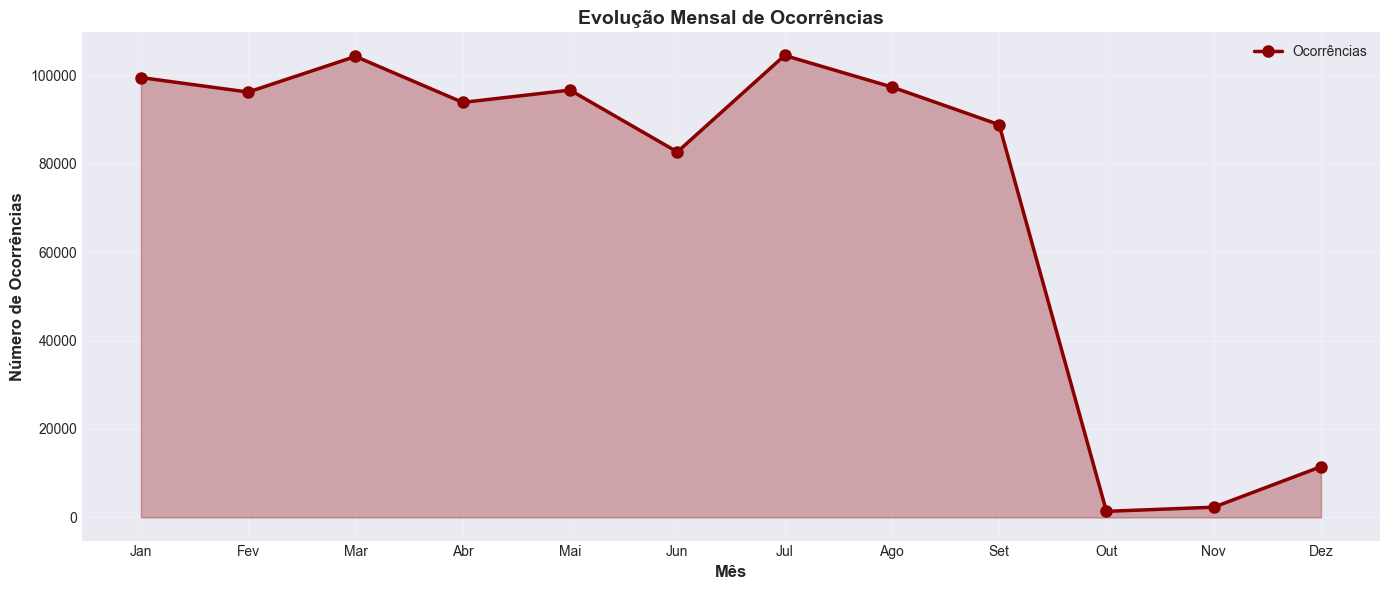


📅 DISTRIBUIÇÃO POR DIA DA SEMANA
  Segunda     122,683 ocorrências (13.96%)
  Terça       130,145 ocorrências (14.81%)
  Quarta      131,190 ocorrências (14.93%)
  Quinta      131,538 ocorrências (14.97%)
  Sexta       132,814 ocorrências (15.12%)
  Sábado      121,964 ocorrências (13.88%)
  Domingo     108,243 ocorrências (12.32%)


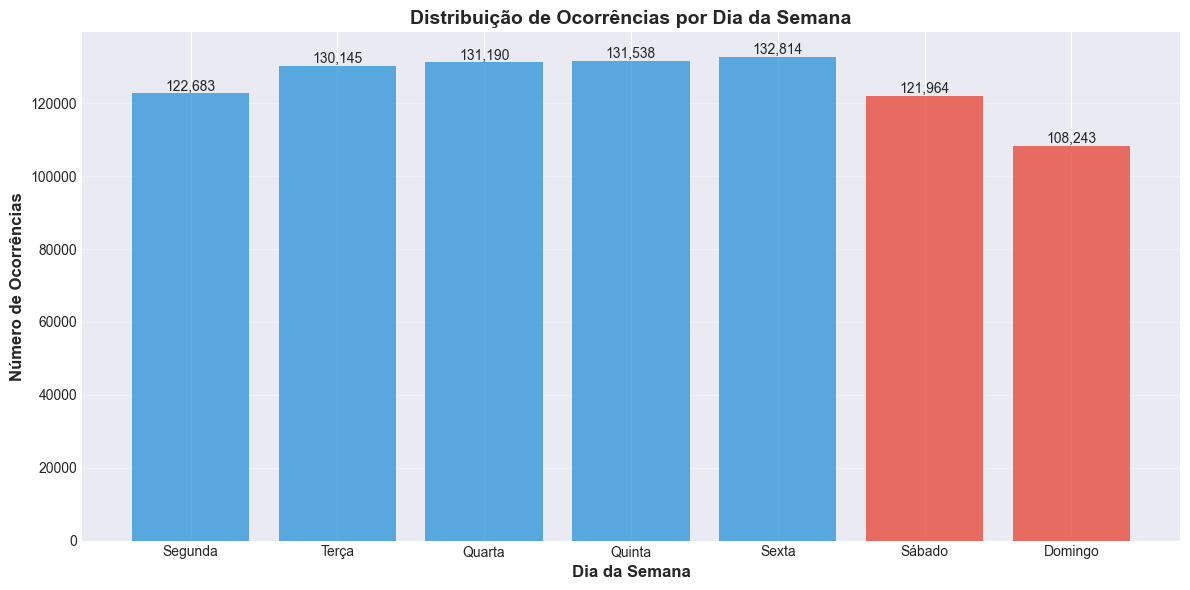


🕐 DISTRIBUIÇÃO POR PERÍODO DO DIA
  nan                   627,733 (71.45%)
  A tarde                64,248 ( 7.31%)
  A noite                59,046 ( 6.72%)
  Pela manhã             54,527 ( 6.21%)
  De madrugada           45,819 ( 5.22%)
  Em hora incerta        27,211 ( 3.10%)
  de madrugada                1 ( 0.00%)


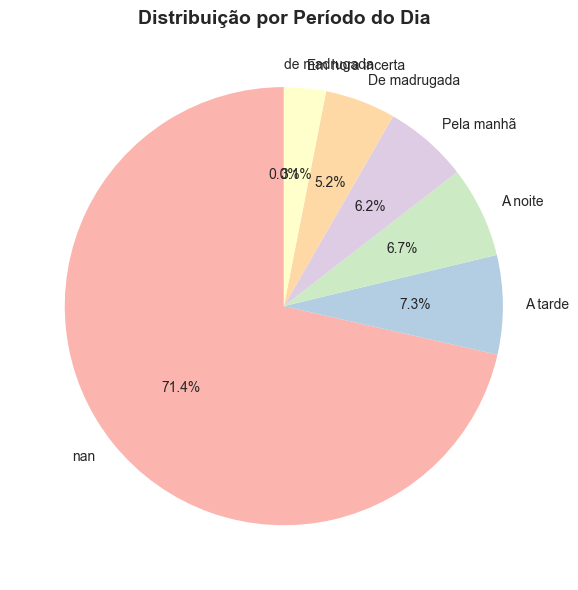

In [5]:
print("="*80)
print("ANÁLISE TEMPORAL")
print("="*80)


# Distribuição por mês
if 'mes_ocorrencia' in df.columns:
    print(f"\n📆 DISTRIBUIÇÃO POR MÊS")
    meses_dist = df['mes_ocorrencia'].value_counts().sort_index()
    
    meses_nomes = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
                   7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'}
    
    for mes, count in meses_dist.items():
        mes_nome = meses_nomes.get(mes, str(mes))
        print(f"  {mes_nome}: {count:>8,} ocorrências ({count/len(df)*100:5.2f}%)")
    
    # Visualização por mês
    fig, ax = plt.subplots(figsize=(14, 6))
    meses_labels = [meses_nomes.get(m, str(m)) for m in meses_dist.index]
    ax.plot(meses_labels, meses_dist.values, marker='o', linewidth=2.5, 
            markersize=8, color='darkred', label='Ocorrências')
    ax.fill_between(range(len(meses_dist)), meses_dist.values, alpha=0.3, color='darkred')
    ax.set_xlabel('Mês', fontweight='bold')
    ax.set_ylabel('Número de Ocorrências', fontweight='bold')
    ax.set_title('Evolução Mensal de Ocorrências', fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Distribuição por dia da semana
if 'dia_semana_nome' in df.columns:
    print(f"\n📅 DISTRIBUIÇÃO POR DIA DA SEMANA")
    dias_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dias_nomes_pt = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
    
    dias_dist = df['dia_semana_nome'].value_counts()
    dias_ordenados = [dias_dist.get(dia, 0) for dia in dias_ordem]
    
    for i, (dia_en, dia_pt) in enumerate(zip(dias_ordem, dias_nomes_pt)):
        count = dias_dist.get(dia_en, 0)
        print(f"  {dia_pt:<10} {count:>8,} ocorrências ({count/len(df)*100:5.2f}%)")
    
    # Visualização
    fig, ax = plt.subplots(figsize=(12, 6))
    colors_dias = ['#3498db' if i < 5 else '#e74c3c' for i in range(7)]
    ax.bar(dias_nomes_pt, dias_ordenados, color=colors_dias, alpha=0.8)
    ax.set_xlabel('Dia da Semana', fontweight='bold')
    ax.set_ylabel('Número de Ocorrências', fontweight='bold')
    ax.set_title('Distribuição de Ocorrências por Dia da Semana', fontweight='bold', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(dias_ordenados):
        ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

# Distribuição por período do dia
if 'desc_periodo' in df.columns:
    print(f"\n🕐 DISTRIBUIÇÃO POR PERÍODO DO DIA")
    periodos_dist = df['desc_periodo'].value_counts()
    
    for periodo, count in periodos_dist.items():
        print(f"  {periodo:<20} {count:>8,} ({count/len(df)*100:5.2f}%)")
    
    # Visualização
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.pie(periodos_dist.values, labels=periodos_dist.index, autopct='%1.1f%%',
           startangle=90, colors=plt.cm.Pastel1(range(len(periodos_dist))))
    ax.set_title('Distribuição por Período do Dia', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

## 6. Análise de Tipos e Categorias de Crime

ANÁLISE DE CRIMES

🚨 DISTRIBUIÇÃO POR CATEGORIA
  Crimes Patrimoniais             626,797 (71.34%)
  Outros                          183,091 (20.84%)
  Crimes de Trânsito               57,750 ( 6.57%)
  Crimes Violentos                 10,947 ( 1.25%)


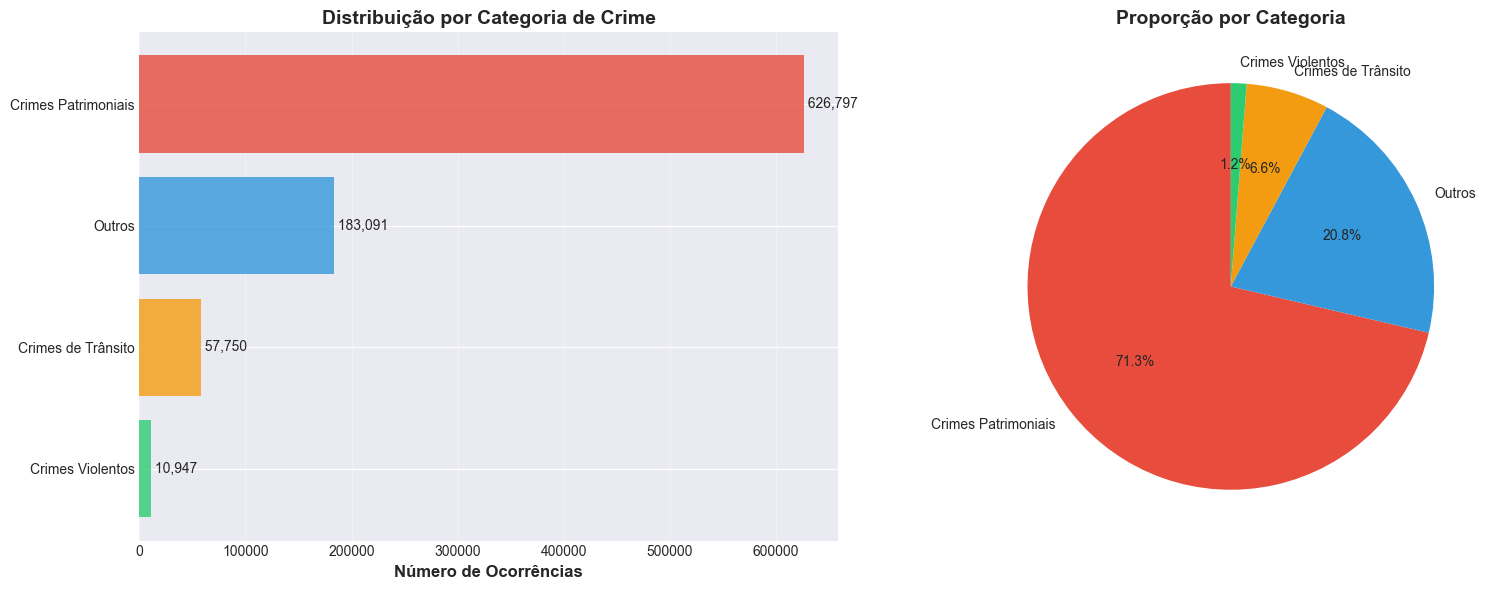


🔝 TOP 20 TIPOS DE CRIME
   1. FURTO - OUTROS                                      415,947 (47.34%)
   2. ROUBO - OUTROS                                      122,849 (13.98%)
   3. LESÃO CORPORAL DOLOSA                               121,324 (13.81%)
   4. FURTO DE VEÍCULO                                     65,808 ( 7.49%)
   5. LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO      54,768 ( 6.23%)
   6. TRÁFICO DE ENTORPECENTES                             34,445 ( 3.92%)
   7. ROUBO DE VEÍCULO                                     19,199 ( 2.19%)
   8. PORTE DE ENTORPECENTES                               10,764 ( 1.23%)
   9. ESTUPRO DE VULNERÁVEL                                 8,405 ( 0.96%)
  10. APREENSÃO DE ENTORPECENTES                            4,892 ( 0.56%)
  11. PORTE DE ARMA                                         4,297 ( 0.49%)
  12. HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO            2,955 ( 0.34%)
  13. TENTATIVA DE HOMICÍDIO                                2,821 ( 0.32%)


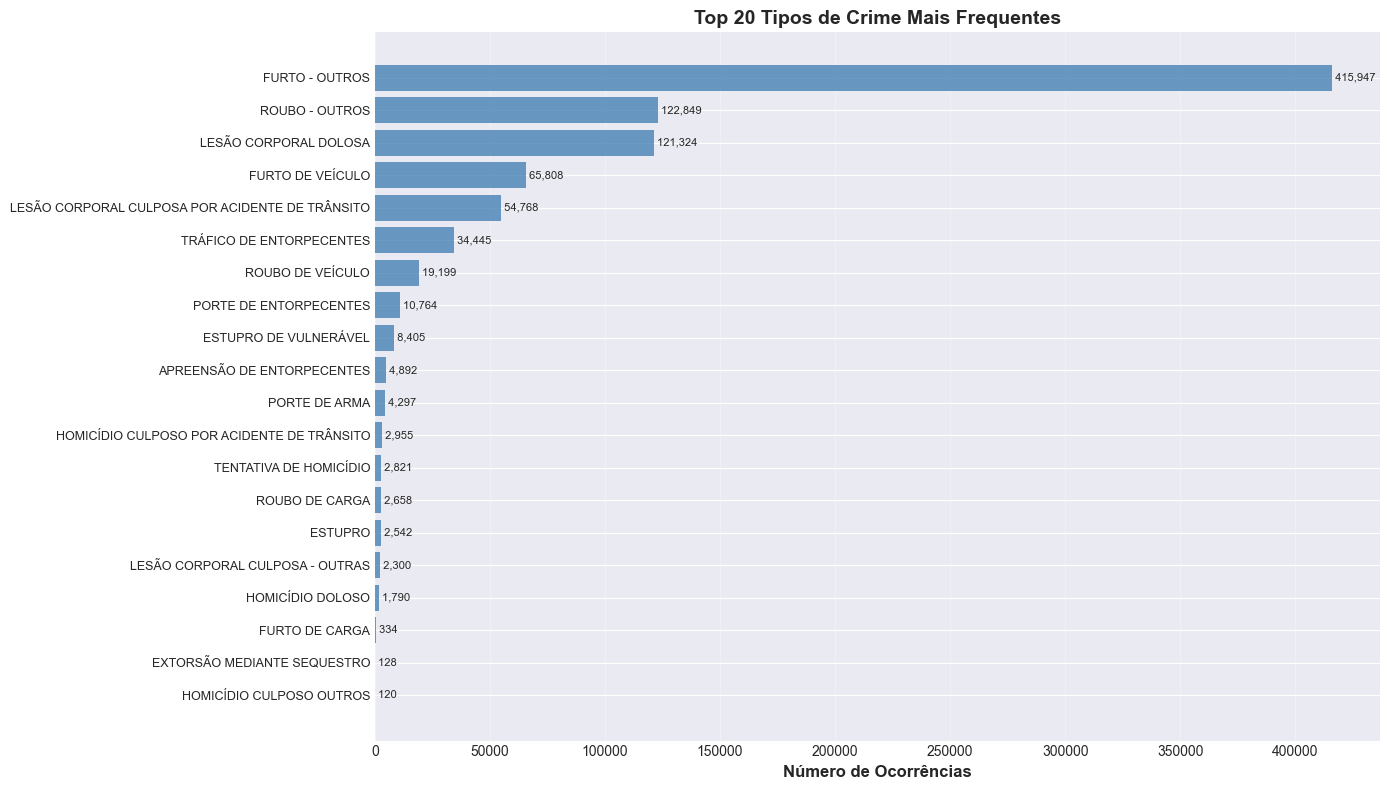


📊 TOP 5 CRIMES POR CATEGORIA

Crimes Violentos:
  1. ESTUPRO DE VULNERÁVEL                           8,405 (76.78%)
  2. ESTUPRO                                         2,542 (23.22%)

Crimes Patrimoniais:
  1. FURTO - OUTROS                                415,947 (66.36%)
  2. ROUBO - OUTROS                                122,849 (19.60%)
  3. FURTO DE VEÍCULO                               65,808 (10.50%)
  4. ROUBO DE VEÍCULO                               19,199 ( 3.06%)
  5. ROUBO DE CARGA                                  2,658 ( 0.42%)

Crimes de Trânsito:
  1. LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO  54,768 (94.84%)
  2. HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO      2,955 ( 5.12%)
  3. HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO          27 ( 0.05%)

Outros:
  1. LESÃO CORPORAL DOLOSA                         121,324 (66.26%)
  2. TRÁFICO DE ENTORPECENTES                       34,445 (18.81%)
  3. PORTE DE ENTORPECENTES                         10,764 ( 5.88%)
  4. APREENSÃ

In [6]:
print("="*80)
print("ANÁLISE DE CRIMES")
print("="*80)

# Distribuição por categoria
if 'categoria_crime' in df.columns:
    print(f"\n🚨 DISTRIBUIÇÃO POR CATEGORIA")
    cat_dist = df['categoria_crime'].value_counts()
    
    for cat, count in cat_dist.items():
        print(f"  {cat:<30} {count:>8,} ({count/len(df)*100:5.2f}%)")
    
    # Visualização
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de barras
    colors_cat = ['#e74c3c', '#3498db', '#f39c12', '#2ecc71']
    axes[0].barh(cat_dist.index, cat_dist.values, color=colors_cat, alpha=0.8)
    axes[0].set_xlabel('Número de Ocorrências', fontweight='bold')
    axes[0].set_title('Distribuição por Categoria de Crime', fontweight='bold', fontsize=14)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(cat_dist.values):
        axes[0].text(v, i, f' {v:,}', va='center', fontsize=10)
    
    # Gráfico de pizza
    axes[1].pie(cat_dist.values, labels=cat_dist.index, autopct='%1.1f%%',
                startangle=90, colors=colors_cat)
    axes[1].set_title('Proporção por Categoria', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Top tipos de crime
if 'tipo_crime' in df.columns:
    print(f"\n🔝 TOP 20 TIPOS DE CRIME")
    tipos_dist = df['tipo_crime'].value_counts().head(20)
    
    for i, (tipo, count) in enumerate(tipos_dist.items(), 1):
        print(f"  {i:2d}. {tipo:<50} {count:>8,} ({count/len(df)*100:5.2f}%)")
    
    # Visualização
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.barh(range(len(tipos_dist)), tipos_dist.values, color='steelblue', alpha=0.8)
    ax.set_yticks(range(len(tipos_dist)))
    ax.set_yticklabels(tipos_dist.index, fontsize=9)
    ax.set_xlabel('Número de Ocorrências', fontweight='bold')
    ax.set_title('Top 20 Tipos de Crime Mais Frequentes', fontweight='bold', fontsize=14)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(tipos_dist.values):
        ax.text(v, i, f' {v:,}', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()

# Crimes por categoria (detalhamento)
if 'categoria_crime' in df.columns and 'tipo_crime' in df.columns:
    print(f"\n📊 TOP 5 CRIMES POR CATEGORIA")
    
    for categoria in df['categoria_crime'].unique():
        if pd.notna(categoria):
            print(f"\n{categoria}:")
            crimes_cat = df[df['categoria_crime'] == categoria]['tipo_crime'].value_counts().head(5)
            
            for i, (crime, count) in enumerate(crimes_cat.items(), 1):
                print(f"  {i}. {crime:<45} {count:>7,} ({count/len(df[df['categoria_crime'] == categoria])*100:5.2f}%)")

## 7. Análise Geográfica (Municípios)

ANÁLISE GEOGRÁFICA

🏙️ ESTATÍSTICAS POR MUNICÍPIO
  Total de municípios: 657
  Média de ocorrências por município: 1337
  Mediana: 146
  Desvio padrão: 13994

🔝 TOP 20 MUNICÍPIOS COM MAIS OCORRÊNCIAS
   1. S.PAULO                              355,042 (40.41%)
   2. CAMPINAS                              25,107 ( 2.86%)
   3. GUARULHOS                             23,636 ( 2.69%)
   4. S.ANDRE                               17,103 ( 1.95%)
   5. S.BERNARDO DO CAMPO                   14,559 ( 1.66%)
   6. OSASCO                                14,049 ( 1.60%)
   7. RIBEIRAO PRETO                        12,879 ( 1.47%)
   8. SOROCABA                              12,741 ( 1.45%)
   9. S.JOSE DO RIO PRETO                   10,266 ( 1.17%)
  10. PRAIA GRANDE                           9,390 ( 1.07%)
  11. SANTOS                                 8,374 ( 0.95%)
  12. S.JOSE DOS CAMPOS                      8,160 ( 0.93%)
  13. DIADEMA                                7,224 ( 0.82%)
  14. S.VICENTE     

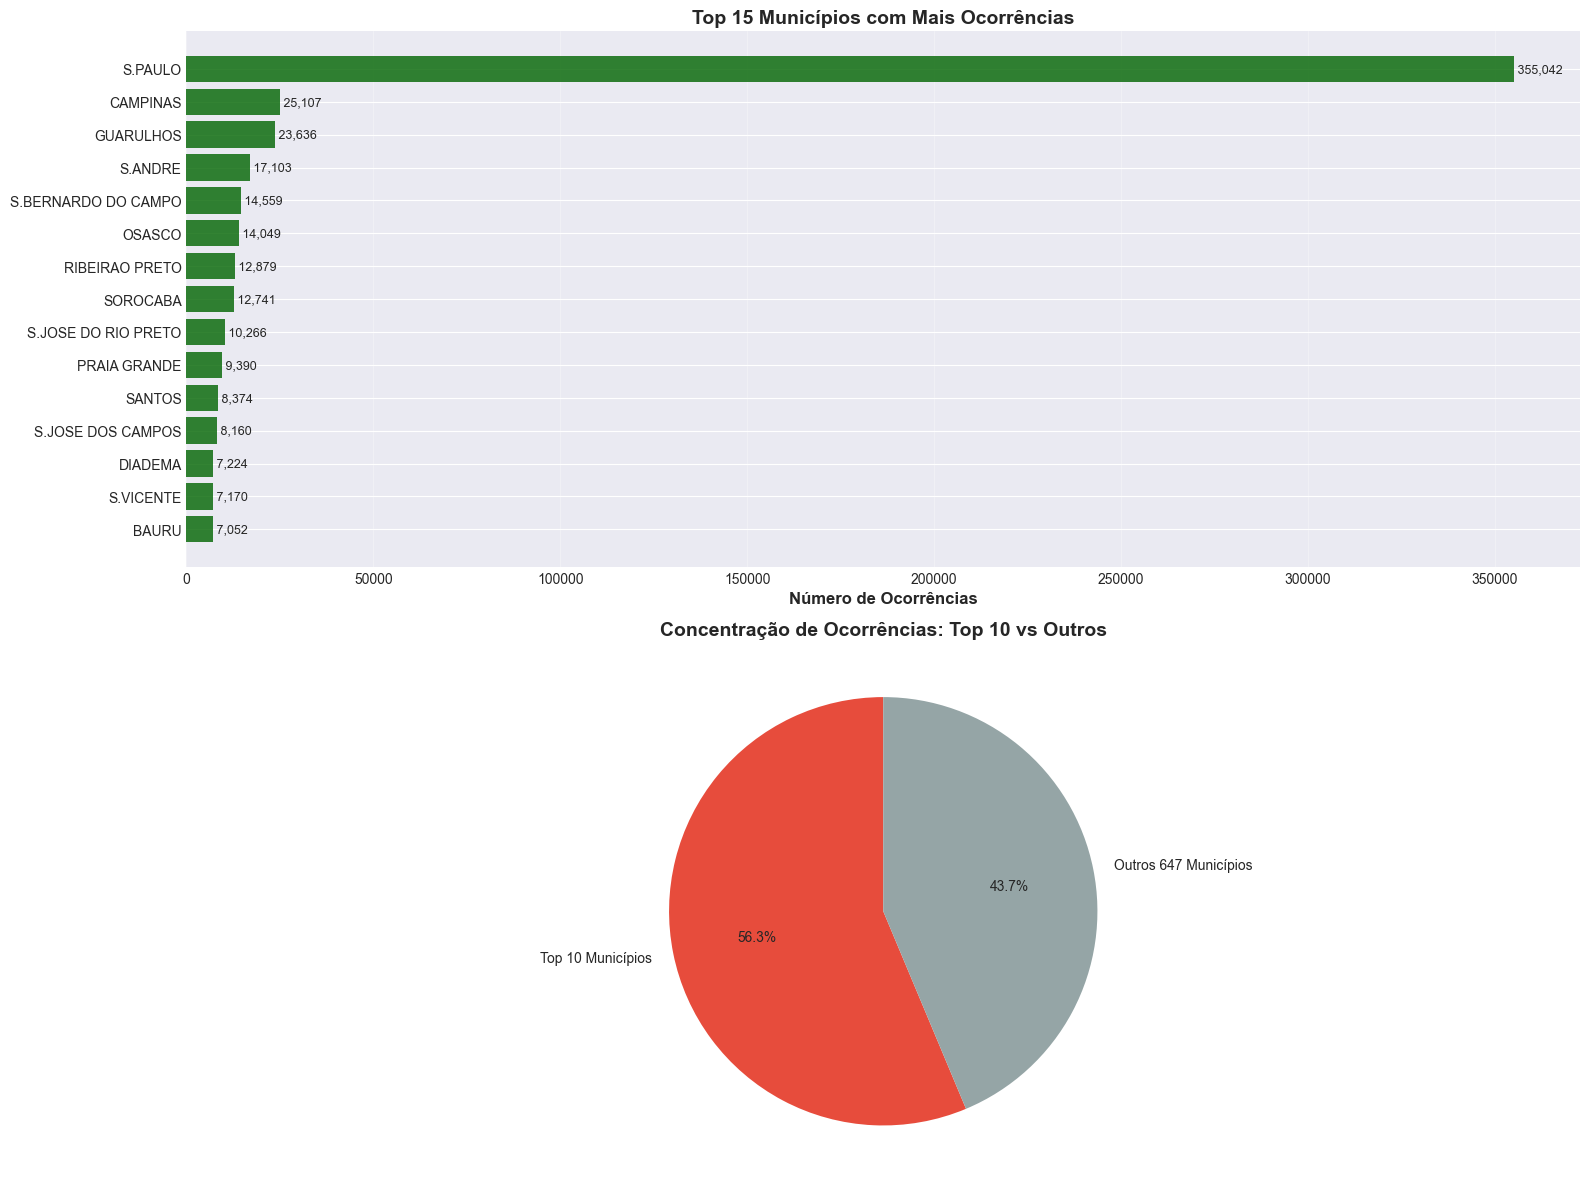


📊 DISTRIBUIÇÃO DE CATEGORIAS NOS TOP 5 MUNICÍPIOS


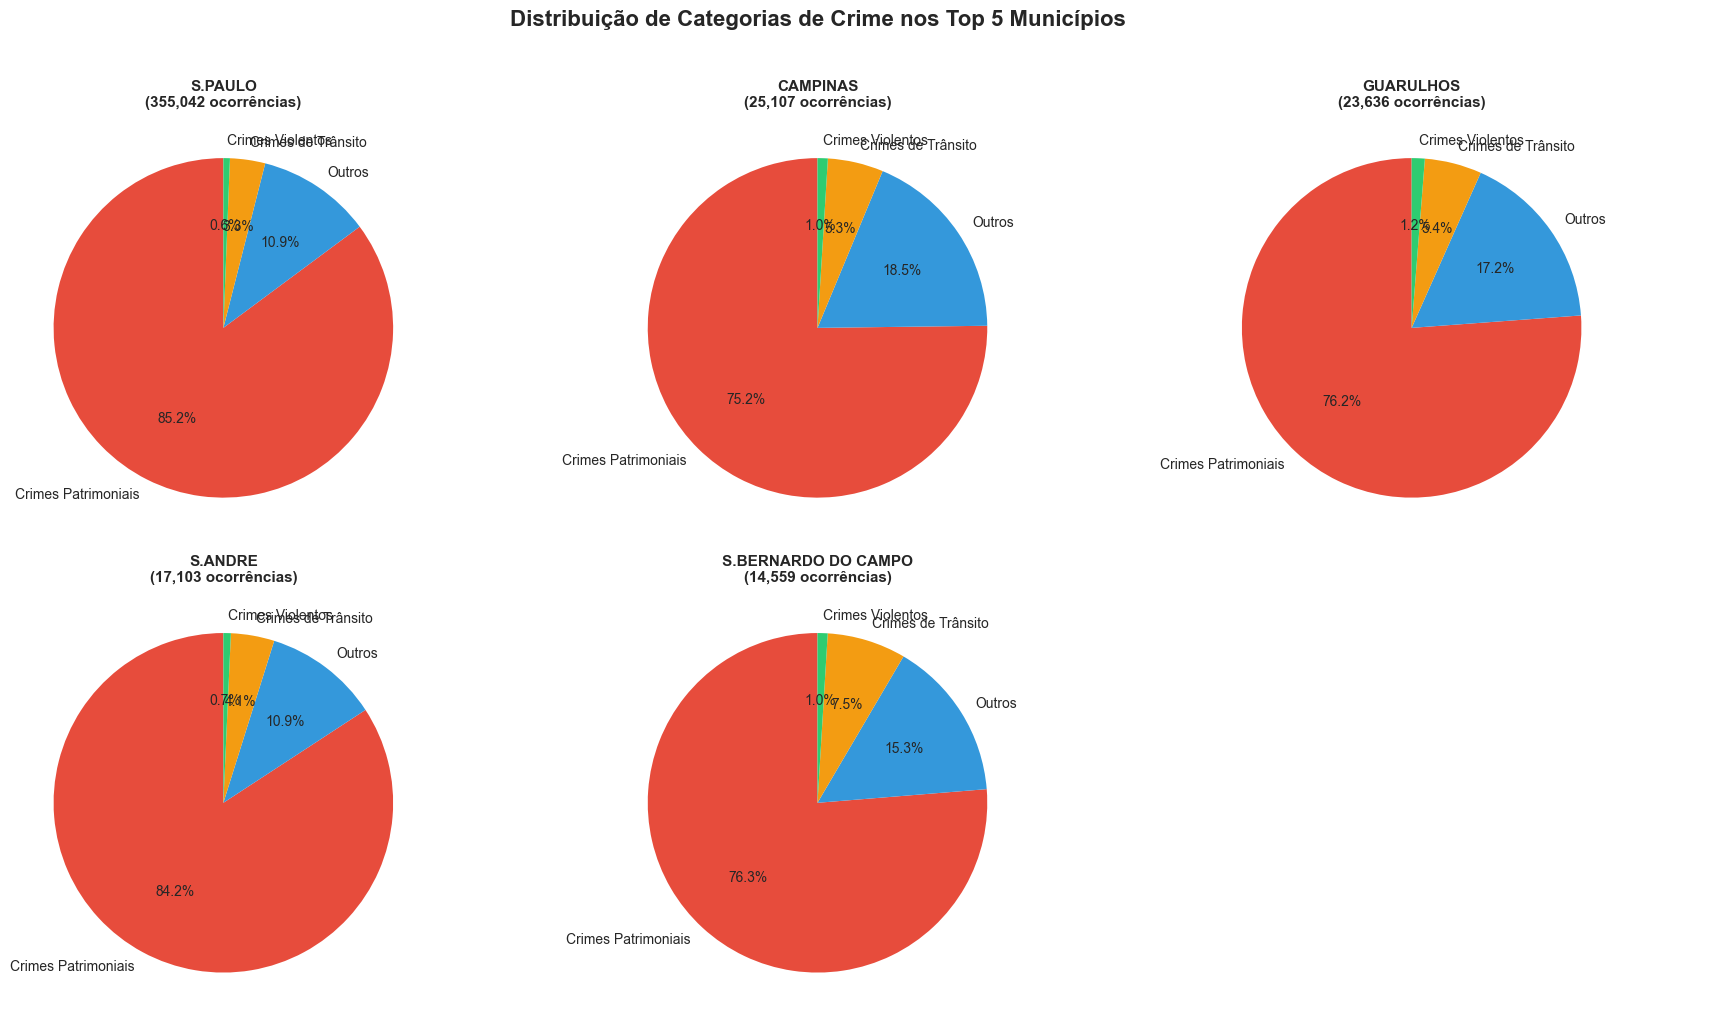


🌍 ANÁLISE DE COORDENADAS
  Registros com coordenadas: 637,016 (72.50%)
  Registros sem coordenadas: 241,569 (27.50%)

  Latitude:
    Mínima: -46.434323
    Máxima: 23.526905
    Média: -23.207789

  Longitude:
    Mínima: -46779670.000000
    Máxima: -40.045135
    Média: -120.428832

  (Visualização: amostra de 50.000 pontos)


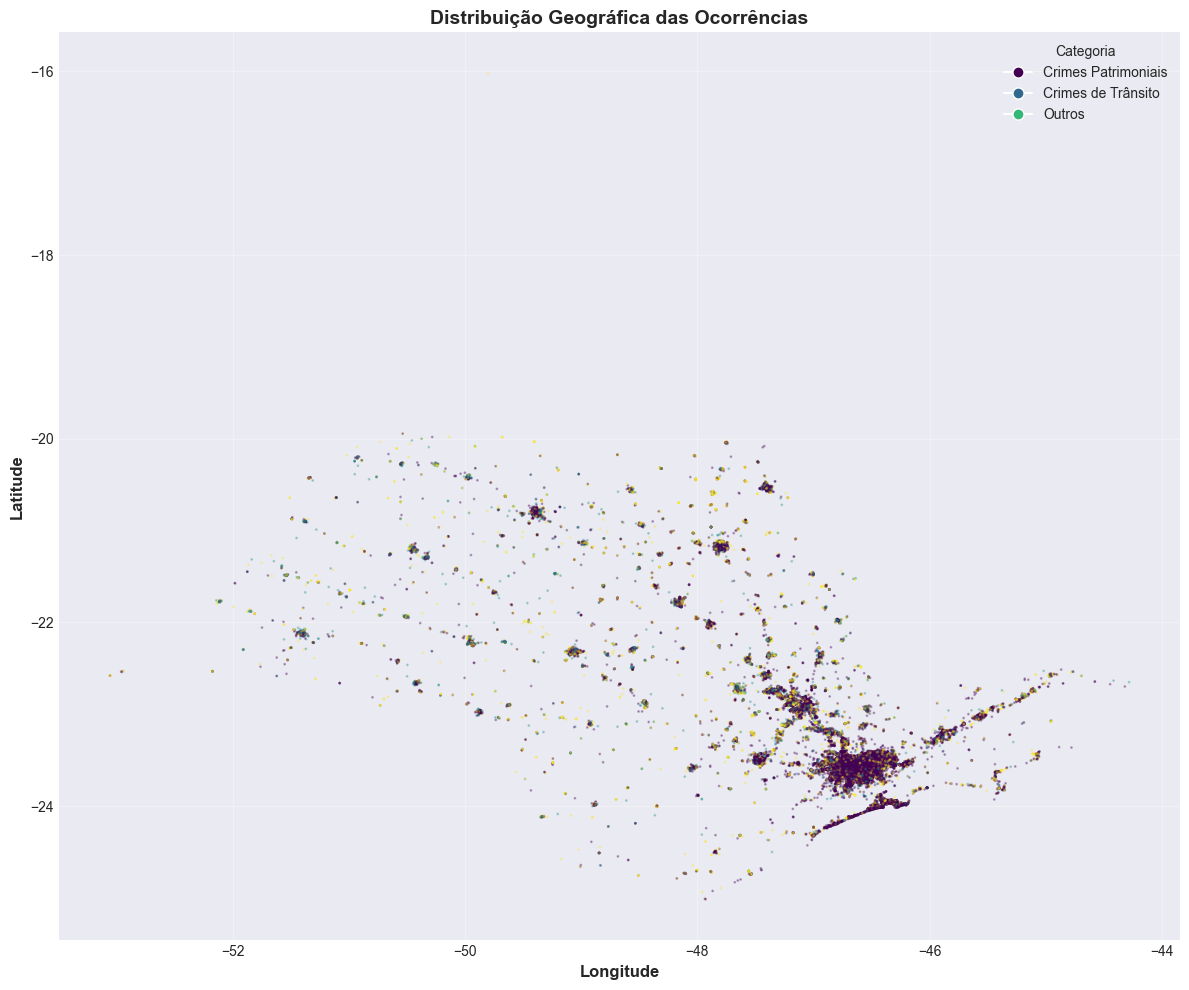

In [7]:
print("="*80)
print("ANÁLISE GEOGRÁFICA")
print("="*80)

# Distribuição por município
if 'nome_municipio' in df.columns:
    print(f"\n🏙️ ESTATÍSTICAS POR MUNICÍPIO")
    print(f"  Total de municípios: {df['nome_municipio'].nunique():,}")
    
    mun_dist = df['nome_municipio'].value_counts()
    print(f"  Média de ocorrências por município: {mun_dist.mean():.0f}")
    print(f"  Mediana: {mun_dist.median():.0f}")
    print(f"  Desvio padrão: {mun_dist.std():.0f}")
    
    print(f"\n🔝 TOP 20 MUNICÍPIOS COM MAIS OCORRÊNCIAS")
    top_municipios = mun_dist.head(20)
    
    for i, (mun, count) in enumerate(top_municipios.items(), 1):
        print(f"  {i:2d}. {mun:<35} {count:>8,} ({count/len(df)*100:5.2f}%)")
    
    # Visualização Top 15
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Top 15 municípios
    top_15 = top_municipios.head(15)
    axes[0].barh(range(len(top_15)), top_15.values, color='darkgreen', alpha=0.8)
    axes[0].set_yticks(range(len(top_15)))
    axes[0].set_yticklabels(top_15.index, fontsize=10)
    axes[0].set_xlabel('Número de Ocorrências', fontweight='bold')
    axes[0].set_title('Top 15 Municípios com Mais Ocorrências', fontweight='bold', fontsize=14)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    for i, v in enumerate(top_15.values):
        axes[0].text(v, i, f' {v:,}', va='center', fontsize=9)
    
    # Concentração: Top 10 vs Outros
    top_10_total = mun_dist.head(10).sum()
    outros_total = mun_dist[10:].sum()
    
    concentracao = pd.Series({
        'Top 10 Municípios': top_10_total,
        f'Outros {df["nome_municipio"].nunique() - 10} Municípios': outros_total
    })
    
    axes[1].pie(concentracao.values, labels=concentracao.index, autopct='%1.1f%%',
                startangle=90, colors=['#e74c3c', '#95a5a6'])
    axes[1].set_title('Concentração de Ocorrências: Top 10 vs Outros', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Análise de categorias por município top 5
    if 'categoria_crime' in df.columns:
        print(f"\n📊 DISTRIBUIÇÃO DE CATEGORIAS NOS TOP 5 MUNICÍPIOS")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        top_5_mun = mun_dist.head(5)
        colors_cat = ['#e74c3c', '#3498db', '#f39c12', '#2ecc71']
        
        for idx, (municipio, _) in enumerate(top_5_mun.items()):
            df_mun = df[df['nome_municipio'] == municipio]
            cat_dist_mun = df_mun['categoria_crime'].value_counts()
            
            axes[idx].pie(cat_dist_mun.values, labels=cat_dist_mun.index, autopct='%1.1f%%',
                         startangle=90, colors=colors_cat)
            axes[idx].set_title(f'{municipio}\n({len(df_mun):,} ocorrências)', 
                               fontweight='bold', fontsize=11)
        
        # Remover eixo extra
        axes[5].axis('off')
        
        plt.suptitle('Distribuição de Categorias de Crime nos Top 5 Municípios', 
                    fontweight='bold', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

# Análise de coordenadas geográficas
if 'latitude' in df.columns and 'longitude' in df.columns:
    print(f"\n🌍 ANÁLISE DE COORDENADAS")
    
    df_coords = df[df[['latitude', 'longitude']].notna().all(axis=1)]
    
    print(f"  Registros com coordenadas: {len(df_coords):,} ({len(df_coords)/len(df)*100:.2f}%)")
    print(f"  Registros sem coordenadas: {len(df) - len(df_coords):,} ({(len(df) - len(df_coords))/len(df)*100:.2f}%)")
    
    if len(df_coords) > 0:
        print(f"\n  Latitude:")
        print(f"    Mínima: {df_coords['latitude'].min():.6f}")
        print(f"    Máxima: {df_coords['latitude'].max():.6f}")
        print(f"    Média: {df_coords['latitude'].mean():.6f}")
        
        print(f"\n  Longitude:")
        print(f"    Mínima: {df_coords['longitude'].min():.6f}")
        print(f"    Máxima: {df_coords['longitude'].max():.6f}")
        print(f"    Média: {df_coords['longitude'].mean():.6f}")
        
        # Scatter plot de coordenadas
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Sample para visualização (se muitos dados)
        if len(df_coords) > 50000:
            df_plot = df_coords.sample(n=50000, random_state=42)
            print(f"\n  (Visualização: amostra de 50.000 pontos)")
        else:
            df_plot = df_coords
        
        scatter = ax.scatter(df_plot['longitude'], df_plot['latitude'], 
                           c=pd.Categorical(df_plot['categoria_crime']).codes,
                           cmap='viridis', alpha=0.3, s=1)
        ax.set_xlabel('Longitude', fontweight='bold')
        ax.set_ylabel('Latitude', fontweight='bold')
        ax.set_title('Distribuição Geográfica das Ocorrências', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3)
        
        # Legenda
        if 'categoria_crime' in df_coords.columns:
            categorias = df_coords['categoria_crime'].unique()
            handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=plt.cm.viridis(i/len(categorias)), 
                                 markersize=8, label=cat) 
                      for i, cat in enumerate(categorias)]
            ax.legend(handles=handles, title='Categoria', loc='best')
        
        plt.tight_layout()
        plt.show()

## 8. Análise de Delegacias

ANÁLISE DE DELEGACIAS

🏛️ ESTATÍSTICAS POR DELEGACIA
  Total de delegacias: 1,415
  Média de ocorrências por delegacia: 621
  Mediana: 101

🔝 TOP 15 DELEGACIAS COM MAIS OCORRÊNCIAS
   1. DELEGACIA ELETRONICA                                254,326 (28.95%)
   2. DELEGACIA ELETRONICA 1                               92,521 (10.53%)
   3. DELEGACIA ELETRONICA 3                               69,909 ( 7.96%)
   4. DELEGACIA ELETRONICA 2                               39,547 ( 4.50%)
   5. DELEGACIA DA MULHER ONLINE                           12,377 ( 1.41%)
   6. DEL.SEC.FRANCA PLANTÃO                                3,783 ( 0.43%)
   7. CPJ RIBEIRAO PRETO                                    3,114 ( 0.35%)
   8. PLANTÃO - 01 DP CAMPINAS                              3,041 ( 0.35%)
   9. 47º D.P. CAPAO REDONDO                                3,003 ( 0.34%)
  10. DEL.SEC.S.J RIO PRETO PLANTÃO                         2,928 ( 0.33%)
  11. DEL.SEC.MARÍLIA PLANTÃO                               2,920 ( 0

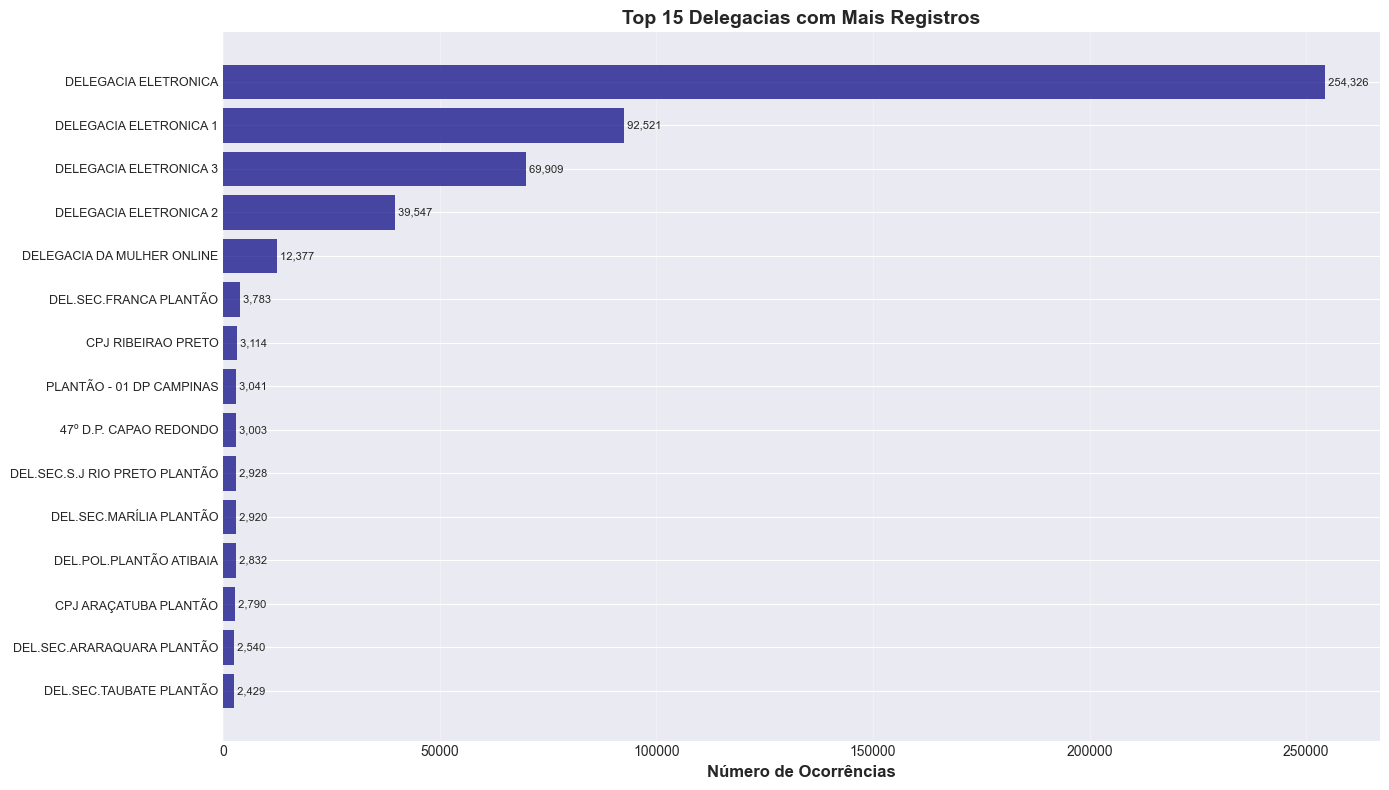


🏢 TOP 10 DEPARTAMENTOS
   1. DIPOL - DEPTO DE INTELIGENCIA             468,683 (53.35%)
   2. DECAP                                      96,821 (11.02%)
   3. DEMACRO                                    65,068 ( 7.41%)
   4. DEINTER 3 - RIBEIRAO PRETO                 37,496 ( 4.27%)
   5. DEINTER 2 - CAMPINAS                       37,241 ( 4.24%)
   6. DEINTER 9 - PIRACICABA                     34,191 ( 3.89%)
   7. DEINTER 7 - SOROCABA                       27,199 ( 3.10%)
   8. DEINTER 6 - SANTOS                         22,801 ( 2.60%)
   9. DEINTER 4 - BAURU                          22,405 ( 2.55%)
  10. DEINTER 1 - SAO JOSE DOS CAMPOS            20,818 ( 2.37%)


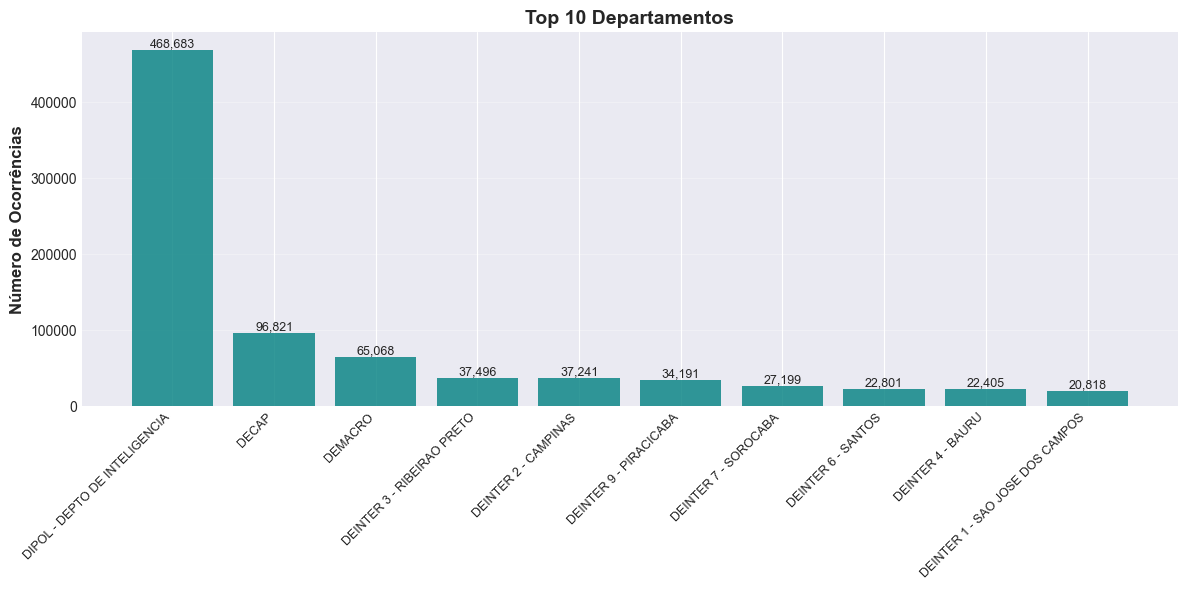

In [8]:
print("="*80)
print("ANÁLISE DE DELEGACIAS")
print("="*80)

# Distribuição por delegacia
if 'nome_delegacia' in df.columns:
    print(f"\n🏛️ ESTATÍSTICAS POR DELEGACIA")
    print(f"  Total de delegacias: {df['nome_delegacia'].nunique():,}")
    
    deleg_dist = df['nome_delegacia'].value_counts()
    print(f"  Média de ocorrências por delegacia: {deleg_dist.mean():.0f}")
    print(f"  Mediana: {deleg_dist.median():.0f}")
    
    print(f"\n🔝 TOP 15 DELEGACIAS COM MAIS OCORRÊNCIAS")
    top_delegacias = deleg_dist.head(15)
    
    for i, (deleg, count) in enumerate(top_delegacias.items(), 1):
        print(f"  {i:2d}. {deleg:<50} {count:>8,} ({count/len(df)*100:5.2f}%)")
    
    # Visualização
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.barh(range(len(top_delegacias)), top_delegacias.values, color='navy', alpha=0.7)
    ax.set_yticks(range(len(top_delegacias)))
    ax.set_yticklabels(top_delegacias.index, fontsize=9)
    ax.set_xlabel('Número de Ocorrências', fontweight='bold')
    ax.set_title('Top 15 Delegacias com Mais Registros', fontweight='bold', fontsize=14)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(top_delegacias.values):
        ax.text(v, i, f' {v:,}', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()

# Distribuição por departamento
if 'nome_departamento' in df.columns:
    print(f"\n🏢 TOP 10 DEPARTAMENTOS")
    dept_dist = df['nome_departamento'].value_counts().head(10)
    
    for i, (dept, count) in enumerate(dept_dist.items(), 1):
        print(f"  {i:2d}. {dept:<40} {count:>8,} ({count/len(df)*100:5.2f}%)")
    
    # Visualização
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(dept_dist)), dept_dist.values, color='teal', alpha=0.8)
    ax.set_xticks(range(len(dept_dist)))
    ax.set_xticklabels(dept_dist.index, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Número de Ocorrências', fontweight='bold')
    ax.set_title('Top 10 Departamentos', fontweight='bold', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(dept_dist.values):
        ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

## 9. Análise de Correlações e Padrões

ANÁLISE DE PADRÕES E CORRELAÇÕES

📊 HEATMAP: CATEGORIAS POR MÊS


ValueError: invalid literal for int() with base 10: '1.0'

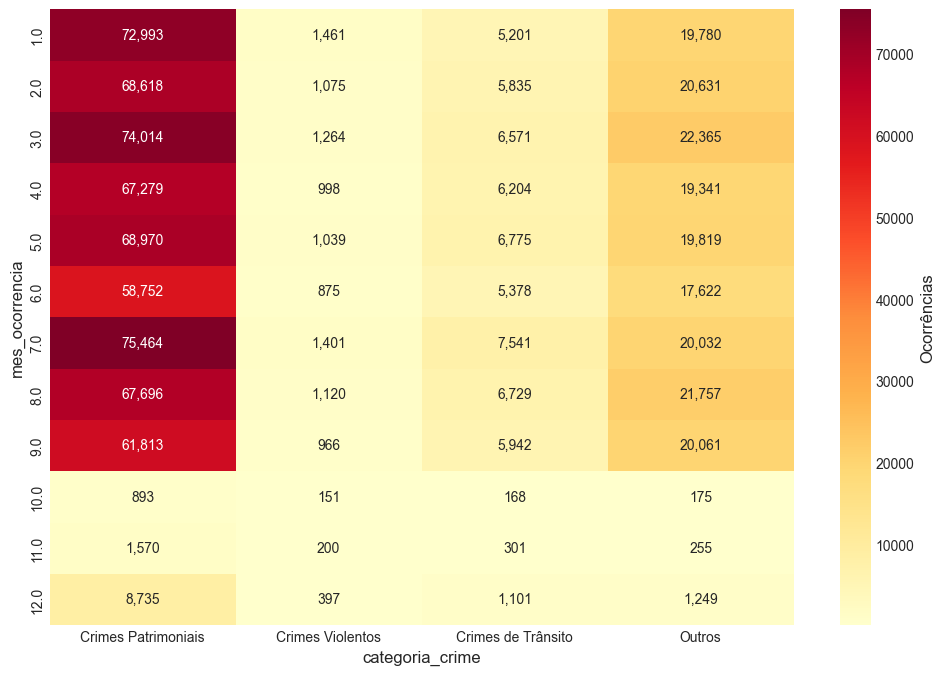

: 

In [ ]:
print("="*80)
print("ANÁLISE DE PADRÕES E CORRELAÇÕES")
print("="*80)

# Heatmap: Crimes por Mês vs Categoria
if 'mes_ocorrencia' in df.columns and 'categoria_crime' in df.columns:
    print(f"\n📊 HEATMAP: CATEGORIAS POR MÊS")
    
    crosstab = pd.crosstab(df['mes_ocorrencia'], df['categoria_crime'])
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(crosstab, annot=True, fmt=',d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Ocorrências'})
    
    meses_nomes = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
                   7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'}
    ax.set_yticklabels([meses_nomes.get(int(i.get_text()), i.get_text()) for i in ax.get_yticklabels()])
    
    ax.set_xlabel('Categoria de Crime', fontweight='bold')
    ax.set_ylabel('Mês', fontweight='bold')
    ax.set_title('Distribuição de Categorias de Crime por Mês', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# Heatmap: Crimes por Dia da Semana vs Categoria
if 'dia_semana' in df.columns and 'categoria_crime' in df.columns:
    print(f"\n📊 HEATMAP: CATEGORIAS POR DIA DA SEMANA")
    
    crosstab_dia = pd.crosstab(df['dia_semana'], df['categoria_crime'])
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(crosstab_dia, annot=True, fmt=',d', cmap='Blues', ax=ax, cbar_kws={'label': 'Ocorrências'})
    
    dias_nomes = {0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 
                  4: 'Sexta', 5: 'Sábado', 6: 'Domingo'}
    ax.set_yticklabels([dias_nomes.get(int(i.get_text()), i.get_text()) for i in ax.get_yticklabels()])
    
    ax.set_xlabel('Categoria de Crime', fontweight='bold')
    ax.set_ylabel('Dia da Semana', fontweight='bold')
    ax.set_title('Distribuição de Categorias de Crime por Dia da Semana', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# Análise de período do dia vs categoria
if 'desc_periodo' in df.columns and 'categoria_crime' in df.columns:
    print(f"\n📊 CRIMES POR PERÍODO DO DIA E CATEGORIA")
    
    crosstab_periodo = pd.crosstab(df['desc_periodo'], df['categoria_crime'], normalize='index') * 100
    
    fig, ax = plt.subplots(figsize=(12, 6))
    crosstab_periodo.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db', '#f39c12', '#2ecc71'], alpha=0.8)
    ax.set_xlabel('Período do Dia', fontweight='bold')
    ax.set_ylabel('Percentual (%)', fontweight='bold')
    ax.set_title('Distribuição Percentual de Categorias por Período do Dia', fontweight='bold', fontsize=14)
    ax.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 10. Resumo Executivo e Insights

In [ ]:
print("="*80)
print("RESUMO EXECUTIVO DA ANÁLISE")
print("="*80)

print(f"\nDADOS GERAIS")
print(f"  Total de ocorrências: {len(df):,}")
print(f"  Período: {df['data_ocorrencia_bo'].min()} a {df['data_ocorrencia_bo'].max()}")
print(f"  Municípios cobertos: {df['nome_municipio'].nunique():,}")
print(f"  Delegacias: {df['nome_delegacia'].nunique():,}")

if 'categoria_crime' in df.columns:
    print(f"\nCATEGORIAS DE CRIME")
    cat_dist = df['categoria_crime'].value_counts()
    for cat, count in cat_dist.items():
        print(f"  {cat}: {count:,} ({count/len(df)*100:.1f}%)")

if 'tipo_crime' in df.columns:
    print(f"\n🔝 TOP 5 CRIMES MAIS FREQUENTES")
    top_5_crimes = df['tipo_crime'].value_counts().head(5)
    for i, (crime, count) in enumerate(top_5_crimes.items(), 1):
        print(f"  {i}. {crime}: {count:,} ({count/len(df)*100:.2f}%)")

if 'nome_municipio' in df.columns:
    print(f"\n🏙️ TOP 5 MUNICÍPIOS")
    top_5_mun = df['nome_municipio'].value_counts().head(5)
    for i, (mun, count) in enumerate(top_5_mun.items(), 1):
        print(f"  {i}. {mun}: {count:,} ({count/len(df)*100:.2f}%)")

if 'mes_ocorrencia' in df.columns:
    print(f"\n📆 DISTRIBUIÇÃO TEMPORAL")
    meses_nomes = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
                   7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}
    mes_mais_crimes = df['mes_ocorrencia'].value_counts().idxmax()
    mes_menos_crimes = df['mes_ocorrencia'].value_counts().idxmin()
    print(f"  Mês com mais crimes: {meses_nomes.get(mes_mais_crimes, mes_mais_crimes)}")
    print(f"  Mês com menos crimes: {meses_nomes.get(mes_menos_crimes, mes_menos_crimes)}")

if 'dia_semana_nome' in df.columns:
    dias_mapeamento = {
        'Monday': 'Segunda-feira', 'Tuesday': 'Terça-feira', 'Wednesday': 'Quarta-feira',
        'Thursday': 'Quinta-feira', 'Friday': 'Sexta-feira', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
    }
    dia_mais_crimes = df['dia_semana_nome'].value_counts().idxmax()
    dia_menos_crimes = df['dia_semana_nome'].value_counts().idxmin()
    print(f"  Dia com mais crimes: {dias_mapeamento.get(dia_mais_crimes, dia_mais_crimes)}")
    print(f"  Dia com menos crimes: {dias_mapeamento.get(dia_menos_crimes, dia_menos_crimes)}")

if 'latitude' in df.columns and 'longitude' in df.columns:
    coords_validas = df[['latitude', 'longitude']].notna().all(axis=1).sum()
    print(f"\n🌍 GEOLOCALIZAÇÃO")
    print(f"  Registros com coordenadas: {coords_validas:,} ({coords_validas/len(df)*100:.1f}%)")
    print(f"  Registros sem coordenadas: {len(df) - coords_validas:,} ({(len(df) - coords_validas)/len(df)*100:.1f}%)")

print(f"\nQUALIDADE DOS DADOS")
print(f"  Duplicatas: {df.duplicated().sum():,}")
print(f"  Valores ausentes (total): {df.isnull().sum().sum():,}")
print(f"  Completude geral: {(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.1f}%")

print(f"\n💡 PRINCIPAIS INSIGHTS")
print(f"  1. Crimes Patrimoniais dominam as estatísticas ({cat_dist.iloc[0]/len(df)*100:.1f}%)")
print(f"  2. Concentração geográfica: Top 10 municípios representam significativa parcela dos crimes")
print(f"  3. {coords_validas/len(df)*100:.1f}% dos registros possuem geolocalização precisa")
print(f"  4. Dados cobrem {df['nome_municipio'].nunique():,} municípios de São Paulo")

if metadata:
    print(f"\nMETADADOS DO PIPELINE ETL")
    print(f"  Data de processamento: {metadata['data_processamento']}")
    print(f"  Transformações aplicadas: {len(metadata['transformacoes_aplicadas'])}")
    print(f"  Arquivos gerados: {len(metadata['arquivos_gerados'])}")

print(f"\n{'='*80}")
print("ANÁLISE EXPLORATÓRIA CONCLUÍDA")
print("="*80)

## Conclusões e Próximos Passos

### Resumo da Análise

Esta análise exploratória (EDA) examinou **878,780 ocorrências criminais** processadas pelo pipeline ETL, revelando:

#### Principais Descobertas:

1. **Distribuição de Crimes**
   - Crimes Patrimoniais: ~71% (furtos, roubos)
   - Outros crimes: ~21%
   - Crimes de Trânsito: ~7%
   - Crimes Violentos: ~1%

2. **Concentração Geográfica**
   - 657 municípios cobertos
   - Forte concentração nos grandes centros urbanos
   - Top 10 municípios concentram parcela significativa

3. **Padrões Temporais**
   - Variações mensais identificadas
   - Padrões semanais observados
   - Distribuição por período do dia mapeada

4. **Qualidade dos Dados**
   - 92% dos registros com geolocalização
   - Duplicatas removidas: 13
   - Alta completude em campos críticos